#### **Creating Dataset**

In [1]:
# First need the data for training - I'll use 'the_verdict.txt'
with open('the-verdict.txt', encoding='utf-8', mode='r') as f:
    text_data = f.read()

print(text_data[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [2]:
# now I'll need a tokenizer to convert these text into tokens
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [3]:
# Make Dataset class to access the data, apply some transfomation and return it by index
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, tokenizer, text_data, context_len, stride):
        # convert text data into tokens
        token_ids = tokenizer.encode(text_data, allowed_special={"<|endoftext|>"})
        self.input_ids = []
        self.target_ids = []

        for i in range(0, len(token_ids) - context_len - 1, stride):
            inp_id = token_ids[i:i+context_len]
            tar_id = token_ids[i+1:i+context_len+1]
            self.input_ids.append(torch.tensor(inp_id))
            self.target_ids.append(torch.tensor(tar_id))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
    
# function to create dataset and dataloader
def create_dataloader(text_data, context_len, batch_size, stride, shuffle=True, drop_last=True):
    # tokenizer
    tokenizer = tiktoken.get_encoding('gpt2')
    data = CustomDataset(tokenizer, text_data, context_len, stride)

    # create a dataloader for this 
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return dataloader


In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [5]:
# Now lets see how many characters I have in this data
total_chars = len(text_data)
print(f"Total characters : {total_chars}")

Total characters : 20479


In [6]:
# we'll take 90% of characters for training and rest 10% for validation
train_text = text_data[:int(0.9*total_chars)]
val_text = text_data[int(0.9*total_chars):]

train_loader = create_dataloader(train_text, GPT_CONFIG_124M['context_length'], 2, 200)
val_loader = create_dataloader(val_text, GPT_CONFIG_124M['context_length'], 2, 200)

print(f"Batches in train loader : {len(train_loader)}")
print(f"Batches in train loader : {len(val_loader)}")
print(f"Each batch contain 2 examples")

Batches in train loader : 11
Batches in train loader : 1
Each batch contain 2 examples


In [7]:
# lets check a batch 
batch1 = next(iter(train_loader))

inputs = batch1[0]
targets = batch1[1]

print(f"Inputs : {inputs.shape}")
print(f"Tragets : {targets.shape}")

Inputs : torch.Size([2, 256])
Tragets : torch.Size([2, 256])


In [8]:
# Defining GPT model #
import os
from transformer_blocks import GPTModel

torch.manual_seed(42)
gpt_model = GPTModel(GPT_CONFIG_124M)

In [9]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device : {device}")

# shifting model to device
gpt_model.to(device)

Using device : mps


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiheadAttention(
        (Wq): Linear(in_features=768, out_features=768, bias=True)
        (Wk): Linear(in_features=768, out_features=768, bias=True)
        (Wv): Linear(in_features=768, out_features=768, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (feedforward): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiheadAttention(
        (Wq): Linear(in_features=768, out_features

In [10]:
# Lets look at number of parameters model have 
total_params = sum(p.numel() for p in gpt_model.parameters())
trainable_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 162,447,360
Trainable parameters: 162,447,360


In [11]:
# now we have structure we need to define optimizer and loss function
epochs = 5
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=1e-3)

#### **Training Loop**

In [12]:
# directory to store training weights
import os
import sys

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

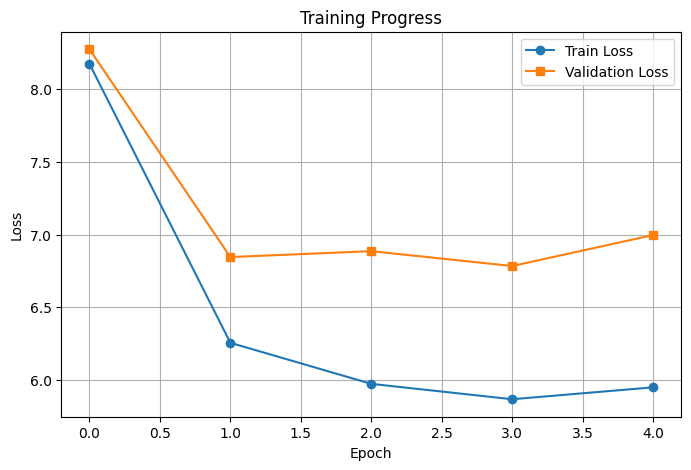

Epoch 5/5 | Train : 5.9504 | Val : 6.9972


In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pdb

train_loss = []
val_loss = []

for epoch in range(epochs):
    gpt_model.train()
    train_loss_epoch = 0
    val_loss_epoch = 0

    ## TRAINING LOOP ##
    for X, y in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        # shape of X and y : [2, 256]
        X, y = X.to(device), y.to(device)
        # shape of preds : [2, 256, 50257]
        preds = gpt_model(X)
        y_flatten = y.flatten(start_dim=0)
        preds_flatten = preds.flatten(start_dim=0, end_dim=1)
        loss = torch.nn.functional.cross_entropy(preds_flatten, y_flatten)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_epoch += loss.item()

    train_loss.append(train_loss_epoch/len(train_loader))

    ## VALIDATION LOOP ##
    with torch.no_grad():
        gpt_model.eval()
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            preds = gpt_model(X)
            y_flatten = y.flatten(start_dim=0)
            preds_flatten = preds.flatten(start_dim=0, end_dim=1)
            loss = torch.nn.functional.cross_entropy(preds_flatten, y_flatten)

            val_loss_epoch += loss.item()
        
    val_loss.append(val_loss_epoch/len(val_loader))

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='s')
    plt.title('Training Progress')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    torch.save(gpt_model.state_dict(), './checkpoints/gpt_model.pth')
    print(f"Epoch {epoch+1}/{epochs} | Train : {train_loss[-1]:.4f} | Val : {val_loss[-1]:.4f}")


    

#### **Predicting Next Tokens**

In [15]:
GPT_CONFIG_124M['context_length']

256

In [16]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
a[-5:]

[6, 7, 8, 9, 10]

In [21]:
model = GPTModel(GPT_CONFIG_124M)

# load weights from .pth file on CPU
state_dict = torch.load("checkpoints/gpt_model.pth", map_location='cpu')

model.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
if __name__ == "__main__":
    user_input = input("Write something : ")
    input_tokens = tokenizer.encode(user_input)
    context_length = GPT_CONFIG_124M['context_length']
    predict_tokens = 100

    for i in range(predict_tokens):
        if len(input_tokens) < context_length:
            input_tensor = torch.tensor(input_tokens).unsqueeze(0)
        else:
            input_tensor = torch.tensor(input_tokens[-256:]).unsqueeze(0)
        with torch.no_grad():
            output_tokens = model(input_tensor)[:, -1, :]
            predicted_token = torch.argmax(output_tokens, dim=-1).squeeze(0)
            input_tokens.append(predicted_token)
    
    decoded_sent = tokenizer.decode(input_tokens)
    print(f"Complete sentence : {decoded_sent}")



Complete sentence : What are you he he was he he of he he he was he he was he he he was he he he he he he he was he was he of he had he had heis

































































